#Learning the confidence of the bounds for linear classifiers in feature space
A ot of work taken from: <br>
[Kernel Methods for Pattern Analysis, Shawe-Tayloir \& Cristianini](https://www.cambridge.org/core/books/kernel-methods-for-pattern-analysis/811462F4D6CD6A536A05127319A8935A),<br>
 [Chpt 4:Detecting Stable Patterns](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/1A8E9D309838F3EEE2CADF18057FC127/9780511809682c4_p85-108_CBO.pdf/detecting-stable-patterns.pdf)

## Applying Deltas
  
1. [Glossary](#sec1)


## Glossary
|Term   | Definition |
|---|---|
|Stable Relation | A pattern that reflects some property of the source data, not a chance feature due to data selection |
| Generalised | Makes corect predicitons about future observations |
| Confidence Parameter $\delta$ | The probability that our pattern is the result of a misleading dataset |
Concentration|  |


In [2]:
# Create 2-d Gaussian surface
import numpy as onp
from jax import jit, grad, random, vmap
import jax.numpy as np
from jax.scipy.stats import multivariate_normal as mvn
import objax

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDOneClassSVM, SGDClassifier, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import torch

import time

## Utility Functions

In [3]:


def get_data(n, d=1, gamma=1):
  mean0 = np.array([d, d])
  mean1 = np.array([-d, -d])
  cov = gamma*np.eye(2)
  ratio = 0.5
  x0 = onp.random.multivariate_normal(mean0, cov, int(ratio*n))
  x1 = onp.random.multivariate_normal(mean1, cov, int((1-ratio)*n))
  X = np.concatenate((x0, x1), axis=0)
  y = onp.ones((n, ))
  y[-int((1-ratio)*n):] = 0

  def optimum_classifier(z, probabilities=True):
      c0 = mvn.pdf(z, mean0, cov)
      c1 = mvn.pdf(z, mean1, cov)
      probs = c0/(c0+c1)
      if not probabilities:
        probs = np.round(probs)
      return probs

  return X, y, optimum_classifier, mean0-mean1

def get_data2(n, d=2, gamma=1):
  mean0 = np.array([d])
  mean1 = np.array([0])
  mean2 = np.array([-d])
  cov = gamma
  x0 = onp.random.normal(mean0, cov, n//2)
  x1 = onp.random.normal(mean1, cov, n)
  x2 = onp.random.normal(mean2, cov, n//2)
  X = np.concatenate((x0, x2, x1), axis=0)
  y = onp.ones((2*n, ))
  
  y[:n] = 0

  def optimum_classifier(z, probabilities=True):
      c0 = mvn.pdf(z, mean1, cov)
      c1a = mvn.pdf(z, mean0, cov)
      c1b = mvn.pdf(z, mean2, cov)
      probs = c0/(c0+0.50*(c1a+c1b))
      if not probabilities:
        probs = np.round(probs)
      return probs

  return X, y, optimum_classifier

## Generate Data

In [4]:
X, y, optimum_classifier, mean = get_data(n=100, d=2)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Fit SVM

In [5]:

# Create SVM pipeline
# clf = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000, tol=1e-3))
clf = LogisticRegression()
clf.fit(X_train,y_train)
print(clf.coef_)


[[1.79282572 1.75175916]]


## Visualise Error

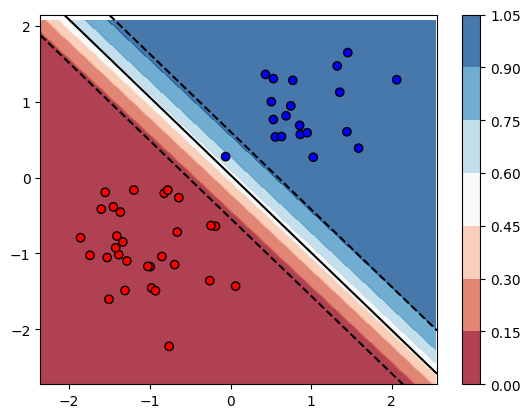

In [6]:


h = 0.1
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = optimum_classifier(np.stack([xx.ravel(), yy.ravel()]).T)
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
plt.colorbar()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k');


# plot the line, the points, and the nearest vectors to the plane
xx = onp.linspace(x_min, x_max, 10)
yy = onp.linspace(y_min, y_max, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = onp.empty(X1.shape)
for (i, j), val in onp.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles);
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)


In [7]:
db = (-(clf.coef_[0][0]) * xx - clf.intercept_)/clf.coef_[0][1]
db_array = np.array((xx,db)).T

In [8]:

projected = np.dot(X_train,clf.coef_.T)/np.linalg.norm(clf.coef_.T)
decision_projected = np.dot(db_array,clf.coef_.T)/np.linalg.norm(clf.coef_.T)

In [9]:
def E(R,N,δ):
    return (R/np.sqrt(N))*(2+np.sqrt(2*np.log(1/δ)))

def supremum(X):
    return np.max(np.array([np.sqrt(x0*x0 + x1*x1) for x0,x1 in X]))

def delta2(R):
    return None

In [10]:
xp1 = np.array([p for i,p in enumerate(projected) if y_train[i] == 0])
xp2 = np.array([p for i,p in enumerate(projected) if y_train[i] == 1])

emp_xp1 = np.mean(xp1)
emp_xp2 = np.mean(xp2)

R_1 = np.max(np.abs(emp_xp1 - xp1))
R_2 = np.max(np.abs(emp_xp2 - xp2))

δ1 = 0.5
δ2 = 0.5
N1 = len(xp1)
N2 = len(xp2)

x_len = np.array([np.sqrt(x0**2+x1**2) for x0,x1 in X_train])

R = supremum(X)

R1 = R_1 + E(R,N1,δ1)
R2 = R_2 + E(R,N2,δ2)


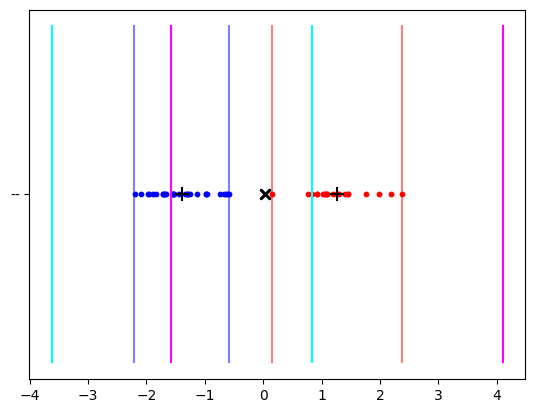

In [11]:

# plt.scatter(projected,np.zeros_like(projected),c=y_train);
plt.scatter(decision_projected,np.zeros_like(decision_projected),c='k',s=50,marker='x');
plt.scatter(xp1,np.zeros_like(xp1),c='b',s=10);
plt.scatter(xp2,np.zeros_like(xp2),c='r',s=10);
plt.scatter(np.array(emp_xp1),0,c='k',s=100,marker='+');
plt.scatter(np.array(emp_xp2),0,c='k',s=100,marker='+');
plt.plot([emp_xp1-R_1,emp_xp1-R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp1+R_1,emp_xp1+R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp2-R_2,emp_xp2-R_2],[-0.5,0.5],'r',alpha=0.5)
plt.plot([emp_xp2+R_2,emp_xp2+R_2],[-0.5,0.5],'r',alpha=0.5)

plt.plot([emp_xp1-R1,emp_xp1-R1],[-0.5,0.5],'cyan','--')
plt.plot([emp_xp1+R1,emp_xp1+R1],[-0.5,0.5],'cyan','--')
plt.plot([emp_xp2-R2,emp_xp2-R2],[-0.5,0.5],'magenta','--')
plt.plot([emp_xp2+R2,emp_xp2+R2],[-0.5,0.5],'magenta','--')



In [12]:
xp1 = np.array([p for i,p in enumerate(projected) if y_train[i] == 0])
xp2 = np.array([p for i,p in enumerate(projected) if y_train[i] == 1])

emp_xp1 = np.mean(xp1)
emp_xp2 = np.mean(xp2)

R_1 = np.max(np.abs(emp_xp1 - xp1))
R_2 = np.max(np.abs(emp_xp2 - xp2))

δ1 = 0.999
δ2 = 0.001
N1 = len(xp1)
N2 = len(xp2)


x_len = np.array([np.sqrt(xp1**2+xp2**2) for xp1,xp2 in list(zip(xp1,xp2))])
R = np.max(x_len)
print(R)
R1 = R_1 + E(R,N1,δ1)
R2 = R_2 + E(R,N2,δ2)


2.6202297


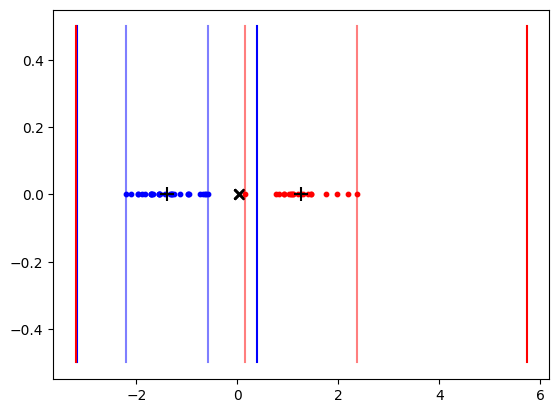

In [13]:

# plt.scatter(projected,np.zeros_like(projected),c=y_train);
plt.scatter(decision_projected,np.zeros_like(decision_projected),c='k',s=50,marker='x');
plt.scatter(xp1,np.zeros_like(xp1),c='b',s=10);
plt.scatter(xp2,np.zeros_like(xp2),c='r',s=10);
plt.scatter(np.array(emp_xp1),0,c='k',s=100,marker='+');
plt.scatter(np.array(emp_xp2),0,c='k',s=100,marker='+');
plt.plot([emp_xp1-R_1,emp_xp1-R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp1+R_1,emp_xp1+R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp2-R_2,emp_xp2-R_2],[-0.5,0.5],'r',alpha=0.5)
plt.plot([emp_xp2+R_2,emp_xp2+R_2],[-0.5,0.5],'r',alpha=0.5)

plt.plot([emp_xp1-R1,emp_xp1-R1],[-0.5,0.5],'b')
plt.plot([emp_xp1+R1,emp_xp1+R1],[-0.5,0.5],'b')
plt.plot([emp_xp2-R2,emp_xp2-R2],[-0.5,0.5],'r')
plt.plot([emp_xp2+R2,emp_xp2+R2],[-0.5,0.5],'r')


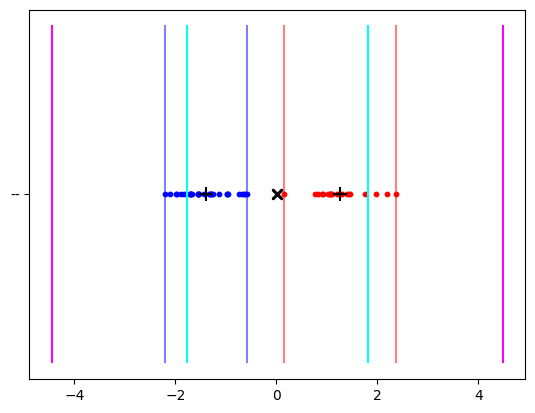

In [14]:

# plt.scatter(projected,np.zeros_like(projected),c=y_train);
plt.scatter(decision_projected,np.zeros_like(decision_projected),c='k',s=50,marker='x');
plt.scatter(xp1,np.zeros_like(xp1),c='b',s=10);
plt.scatter(xp2,np.zeros_like(xp2),c='r',s=10);
plt.scatter(np.array(emp_xp1),0,c='k',s=100,marker='+');
plt.scatter(np.array(emp_xp2),0,c='k',s=100,marker='+');
plt.plot([emp_xp1-R_1,emp_xp1-R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp1+R_1,emp_xp1+R_1],[-0.5,0.5],'b',alpha=0.5)
plt.plot([emp_xp2-R_2,emp_xp2-R_2],[-0.5,0.5],'r',alpha=0.5)
plt.plot([emp_xp2+R_2,emp_xp2+R_2],[-0.5,0.5],'r',alpha=0.5)


decision_projected_0 = decision_projected[0]
plt.plot([decision_projected_0-R1,decision_projected_0-R1],[-0.5,0.5],'cyan','--')
plt.plot([decision_projected_0+R1,decision_projected_0+R1],[-0.5,0.5],'cyan','--')
plt.plot([decision_projected_0-R2,decision_projected_0-R2],[-0.5,0.5],'magenta','--')
plt.plot([decision_projected_0+R2,decision_projected_0+R2],[-0.5,0.5],'magenta','--')



In [15]:
x = np.linspace(0.001,0.999,100)
y = 2 + np.sqrt(2*np.log(1/x))

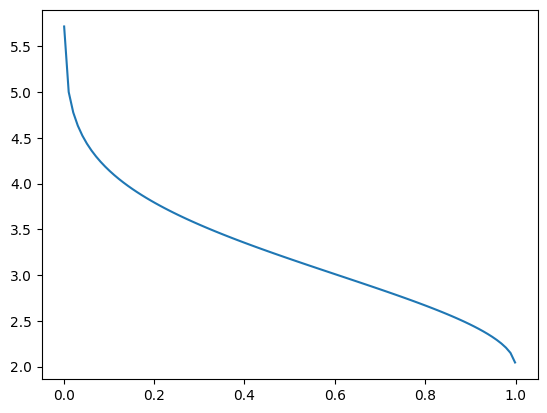

In [16]:
plt.plot(x,y)

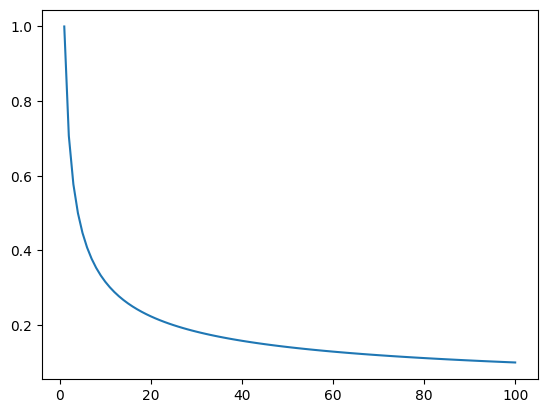

In [17]:
x = np.linspace(1,100,100)
y = 1/np.sqrt(x)
plt.plot(x,y)

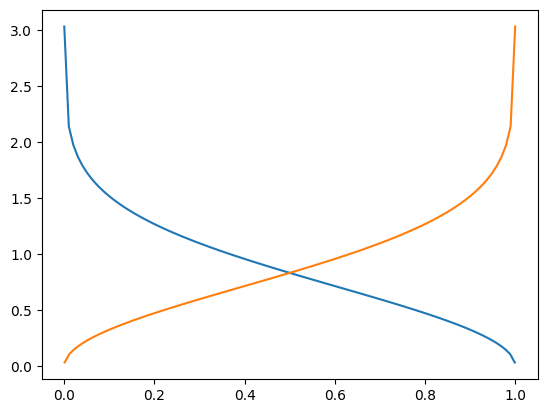

In [18]:
x = np.linspace(0.0001,0.999,100)
y = np.sqrt(np.log(1/x))
plt.plot(x,y)
plt.plot(1-x,y)

In [19]:
R = 2
N = [1,5,100]

δ = np.linspace(0.001,0.999,3)
y = 2 + np.sqrt(2*np.log(1/δ))

for n in N:
    res = R/np.sqrt(n)*y
    print(n,':',res)

1 : [11.433845   6.3548203  4.089465 ]
5 : [5.113371  2.8419619 1.8288643]
100 : [1.1433845 0.635482  0.4089465]


In [20]:
R = 5
N = [1,5,100]

δ = np.linspace(0.001,0.999,3)
y = 2 + np.sqrt(2*np.log(1/δ))

for n in N:
    res = R/np.sqrt(n)*y
    print(n,':',res)

1 : [28.584612 15.887051 10.223663]
5 : [12.783427  7.104905  4.572161]
100 : [2.8584611 1.5887051 1.0223663]


In [21]:
c1 = 1
c2 = 1

N1 = 10
N2 = 10

δ1 = 0.5
δ2 = np.linspace(0.001,0.999,3)

J = (1-δ1)*(1/(N1+1)) + δ1 + (1-δ2)*(1/(N2+1)) + δ2
print(J)

[0.6372727 1.0909091 1.5445454]


In [22]:
X = [[0,0],
     [1,0],
     [0,0]]

Y = [[0,0],
     [1,0],
     [0,0]]

- scale data ($\mu=0,\sigma=1$)
- $R = \sup_{\mathbf{x}\in{X}} || \phi(\mathbf{x})||$

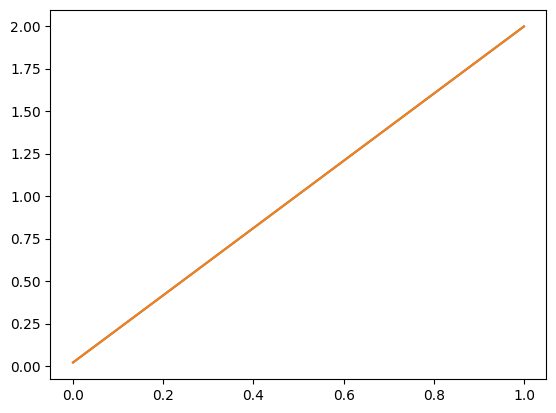

In [23]:
c1 = 1
c2 = 1

N1 = 100
N2 = 100

δ1 = np.linspace(0.001,0.999,100)
δ2 = np.linspace(0.001,0.999,100)

J = (1-δ1)*(1/(N1+1)) + δ1 + (1-δ2)*(1/(N2+1)) + δ2

plt.plot(δ2,J)
plt.plot(δ1,J)